In [14]:
import logging
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from matplotlib import cm
from copy import copy

logging.basicConfig(
    format="[%(asctime)s] %(levelname)s: %(message)s",
    datefmt="%H:%M:%S",
    level=logging.INFO,
)

In [15]:
def rastrigin(x, A=10):
    """NumPy Rastrigin test function"""
    return -np.sum(A - A * np.cos(2 * np.pi * x) + x**2, axis=0)

def sphere(x, A=10):
    """NumPy sphere test function"""
    return -np.sum(x**2, axis=0)

## (1+1)-ES

In [16]:
def es_1(evaluate: callable, sigma):
    def tweak(solution, sigma):
        new_solution = np.array([(e + np.random.normal(0, sigma)) for e in solution])
        return new_solution
    current_solution = np.random.uniform(-5, 5, (2,))
    taken = []
    taken.append(current_solution)
    useless_steps = 0
    while useless_steps < 50_000:
        useless_steps += 1
        candidate_solution = tweak(current_solution, sigma)
        if evaluate(candidate_solution) > evaluate(current_solution):
            useless_steps = 0
            current_solution = copy(candidate_solution)
            taken.append(current_solution)
    return current_solution, taken

## (1 + $\lambda$)-ES

In [17]:
def es_2(evaluate: callable, sigma, _lambda):

    def tweak(solution):
        new_solution = np.random.normal(0, sigma, size=(_lambda, np.size(solution))) + solution
        return new_solution
    
    current_solution = np.random.uniform(-5, 5, (2,))
    taken = []
    taken.append(current_solution)
    useless_steps = 0
    while useless_steps < 50_000:
        useless_steps += 1
        candidate_solution = tweak(current_solution)
        evaluation = evaluate(candidate_solution.T)
        idx = np.argmax(evaluation)
        if evaluate(candidate_solution[idx]) > evaluate(current_solution):
            useless_steps = 0
            current_solution = copy(candidate_solution[idx])
            taken.append(current_solution)
    return current_solution, taken

## (1 , $\lambda$)-ES

In [23]:
def es_comma(evaluate: callable, sigma, _lambda):

    def tweak(solution):
        new_solution = np.random.normal(0, sigma, size=(_lambda, np.size(solution))) + solution
        return new_solution
    
    def comma_choice(candidate_solution):
        evaluation = evaluate(candidate_solution.T)
        idx = np.argmax(evaluation) 
        new_solution = copy(candidate_solution[idx])      
        return new_solution
            
    
    current_solution = np.random.uniform(-5, 5, (2,))
    candidate_solution = None
    taken = []
    taken.append(current_solution)

    while candidate_solution is None or np.linalg.norm(evaluate(current_solution) - evaluate(candidate_solution)) >= 1e-4:
        candidate_solution = tweak(current_solution)
        candidate_solution = comma_choice(candidate_solution)
        taken.append(candidate_solution)
        current_solution, candidate_solution = candidate_solution, current_solution
            
    return current_solution, taken

## Compute solution

In [24]:
collection = []

found_s, path = es_comma(rastrigin, 1, 10000000)
print(f"ES-Comma: (x, y): {found_s}, z: {rastrigin(found_s)} d_max = {np.linalg.norm(rastrigin(found_s)-np.array([0,0]))}")
collection.append(found_s)

found_s, path = es_2(rastrigin, 4, 10)
print(f"ES-1+lambda: (x, y): {found_s}, z: {rastrigin(found_s)} d_max = {np.linalg.norm(rastrigin(found_s)-np.array([0,0]))}")
collection.append(found_s)

found_s, path = es_1(rastrigin, 2)
print(f"ES-1+1: (x, y): {found_s}, z: {rastrigin(found_s)} d_max = {np.linalg.norm(rastrigin(found_s)-np.array([0,0]))}")
collection.append(found_s)

print(np.argmax(rastrigin(c) for c in collection))



ES-Comma: (x, y): [0.00010852 0.00042457], z: -3.8098416983456106e-05 d_max = 5.387929800294908e-05
ES-1+lambda: (x, y): [-0.00112491  0.00087198], z: -0.00040189701899862593 d_max = 0.0005683682149451743
ES-1+1: (x, y): [0.0046155  0.00086745], z: -0.004375297859905004 d_max = 0.0061876055728996345
0


<Axes3DSubplot: >

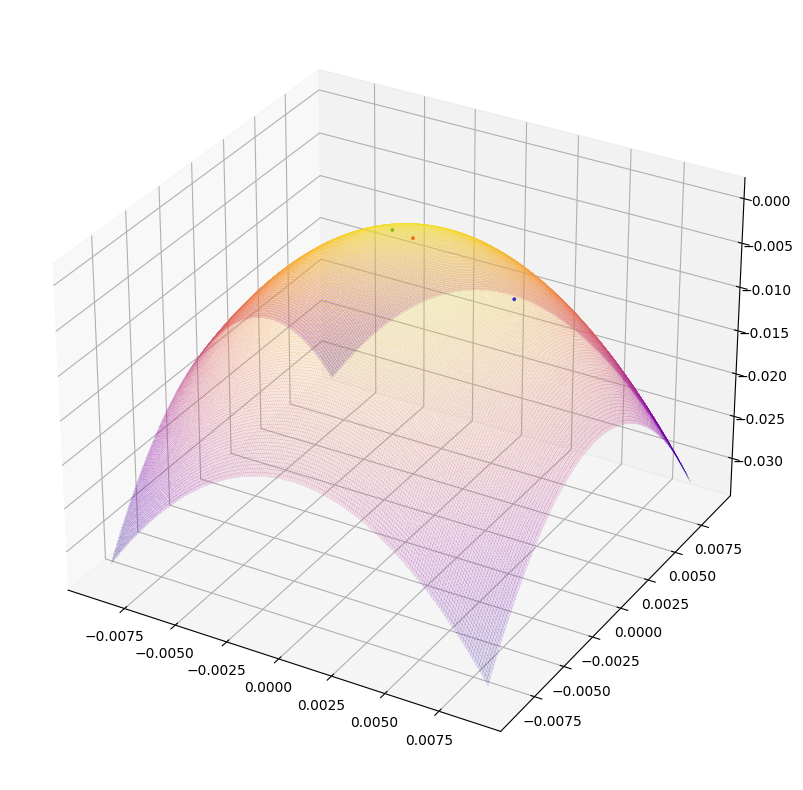

In [26]:
xp = np.array([e[0] for e in collection])
yp = np.array([e[1] for e in collection])
zp = np.array([rastrigin(e) for e in collection])
N_POINTS = 200
r = np.linspace(-0.009, 0.009, N_POINTS)
x = np.array(np.meshgrid(r, r))
z = rastrigin(x)
# z = sphere(x)
plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")
ax.plot_surface(*np.meshgrid(r, r), z, alpha=0.1, rstride=1, cstride=1, cmap=cm.plasma, linewidth=0, antialiased=False)
#ax.plot(xp, yp, zp, color='black')
ax.scatter(xp, yp, zp, alpha=1, color=['red','green','blue'], marker='o', s=3)
ax

In [27]:
found_s, path = es_comma(rastrigin, 1, 100000)

<Axes3DSubplot: >

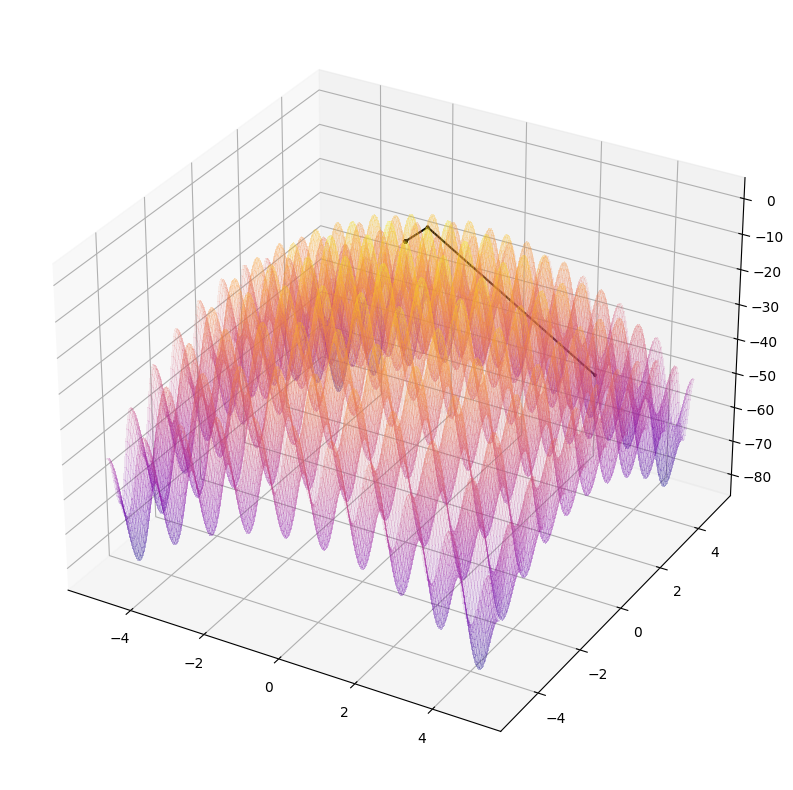

In [28]:
xp = np.array([e[0] for e in path])
yp = np.array([e[1] for e in path])
zp = np.array([rastrigin(e) for e in path])
N_POINTS = 200
r = np.linspace(-5, 5, N_POINTS)
x = np.array(np.meshgrid(r, r))
z = rastrigin(x)
# z = sphere(x)
plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")
ax.plot_surface(*np.meshgrid(r, r), z, alpha=0.1, rstride=1, cstride=1, cmap=cm.plasma, linewidth=0, antialiased=False)
ax.plot(xp, yp, zp, color='black')
ax.scatter(xp, yp, zp, alpha=1, color='black', marker='o', s=3)
ax

In [29]:
zp

array([-5.55540612e+01, -1.15036161e+00, -7.07703036e-05, -1.18268501e-05,
       -6.42695482e-06, -1.63793560e-05, -4.95496112e-05, -5.56395999e-05,
       -1.01457130e-05, -2.94526470e-05, -3.38873474e-05, -2.73140081e-05,
       -2.48018629e-06, -5.73002839e-05, -2.20765623e-05, -4.55581595e-06,
       -1.52231613e-06, -1.40001554e-05, -1.18844673e-05, -6.47846798e-05,
       -9.30894009e-06, -3.09008852e-05, -2.53470483e-05, -8.17311287e-06,
       -1.38257178e-05, -5.18079147e-05, -2.99224647e-05, -3.61704773e-05,
       -2.90329776e-05, -2.80226092e-05, -9.65590552e-05, -1.00923434e-05,
       -9.79705791e-05, -1.20662367e-05, -4.91566868e-05, -1.78107505e-05,
       -1.13835223e-04, -5.54574091e-06, -1.97287798e-05, -1.52802126e-05,
       -2.85952269e-05, -3.42239142e-05, -5.87828729e-05, -4.49152478e-05,
       -6.35168137e-05, -1.56847674e-05, -2.36078039e-05, -1.46831754e-04,
       -8.77345579e-07, -8.70872782e-06, -7.12864195e-06, -8.19220471e-05,
       -6.59179423e-06, -